In [1]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/branch_full/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
from branch_v2 import Net
# from compare_performance import compare_performance
from branch_NPP24 import Net_NPP24
from galerkin import DGMNet
from bsde import BSDENet
import logging

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# perfect reproducibility is not guaranteed with different version of torch
#
import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 2.5.1+cu124
torchaudio version: 2.5.1+cu124
torchvision version: 0.20.1+cu124


In [3]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Fri Nov 22 08:48:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000               Off |   00000000:21:00.0  On |                  Off |
| 41%   38C    P8             14W /  140W |    1744MiB /  16376MiB |      5%      Default |
|                                         |                        |                  N/A |
+-------------

In [4]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    disable_branch_NPP23=False,
    seeds=list(range(10)),
    **kwargs,
):
    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

#    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    fname = f"{fname}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_NPP23_runtime, branch_NPP23_l1_error, branch_NPP23_l2_error, branch_NPP23_rel_error, branch_NPP23 = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_total_runtime = []
    branch_NPP23_fdb_runtime, branch_NPP23_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_hi, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_runtime.append(branch_total_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )
            
        ######### NPP23 Deep branching method
        if not disable_branch_NPP23:
            torch.manual_seed(seed)
            print(
                f"#### Starting NPP23 deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model_NPP23 = Net_NPP23(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model_NPP23.train_and_eval(debug_mode)
            branch_NPP23_total_runtime.append(time.time() - start)
            branch_NPP23_fdb_runtime.append(model_NPP23.fdb_runtime)
            branch_NPP23_runtime.append(branch_NPP23_total_runtime[-1] - branch_NPP23_fdb_runtime[-1])
            tmp = (
                model_NPP23(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch_NPP23 += tmp
            branch_NPP23_l1_error.append((np.abs(tmp - true)).mean())
            branch_NPP23_l2_error.append(((tmp - true) ** 2).mean())
            branch_NPP23_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_NPP23_runtime[-1]:.0f} seconds; L1 error: {branch_NPP23_l1_error[-1]:.2E}; L2 error: {branch_NPP23_l2_error[-1]:.2E}; rel error: {branch_NPP23_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_NPP23_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_NPP23_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_total_runtime = np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )
            
    if not disable_branch_NPP23:
        branch_NPP23 /= len(seeds)
        branch_NPP23_runtime, branch_NPP23_l1_error, branch_NPP23_l2_error, branch_NPP23_rel_error = (
            np.array(branch_NPP23_runtime),
            np.array(branch_NPP23_l1_error),
            np.array(branch_NPP23_l2_error),
            np.array(branch_NPP23_rel_error),
        )
        branch_NPP23_fdb_runtime, branch_NPP23_total_runtime = np.array(
            branch_NPP23_fdb_runtime
        ), np.array(branch_NPP23_total_runtime)
        print("\n")
        print("######## Summary for NPP23 deep branching method")
        print(f"runtime:        {branch_NPP23_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_NPP23_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_NPP23_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_NPP23_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_NPP23_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_NPP23_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_NPP23_l2_error.std():.2E}")
        print(f"mean rel error: {branch_NPP23_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_NPP23_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch_NPP23, label="NPP23 Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch_NPP23, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_NPP23_runtime, branch_NPP23_l1_error, branch_NPP23_l2_error, branch_NPP23_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.grid()
    fname = f"{fname}_dim_{dim}" if fname is not None else f"demo_dim_{dim}"
    plt.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    plt.show()
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

## Exponential nonlinearity in dimension d = 1 with T = 0.5

In [5]:
# function definition
fixed_dim, dim = 0, 1

problem_name = f"exp_dim_{dim}"

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4*torch.exp(-y) - 10*torch.exp(-y/2) + torch.exp(y/2) - torch.exp(y) # y - y ** 3

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4*torch.exp(-y[0]) - 10*torch.exp(-y[0]/2) + torch.exp(y[0]/2) - torch.exp(y[0]) # y - y ** 3

deriv_map = np.array([0]).reshape(-1, 1)

dgm_deriv_map = np.array([0, 1, 2]).reshape(-1, 1)

def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    return .5 * y[2] + 6 + 4*torch.exp(-y[0]) - 10*torch.exp(-y[0]/2) + torch.exp(y[0]/2) - torch.exp(y[0]) # y[0] - y[0] ** 3

def phi_example(x):
    return 2*torch.log(1+1/(1+torch.exp(x.sum(dim=0) / math.sqrt(dim)))) # -0.5 - 0.5 * torch.nn.Tanh()(-.5 * x.sum(dim=0) / math.sqrt(dim))

def exact_example(t, x, T):
    return 2*np.log(1+1/(1+np.exp(x.sum(axis=0) / math.sqrt(dim)-(T-t)))) # -0.5 - 0.5 * np.tanh(-.5*x.sum(axis=0)/math.sqrt(dim) + 3*(T-t)/4)

t_lo, t_hi, x_lo, x_hi, n = 0., 0., -4., 4., 1
grid = np.linspace(x_lo, x_hi, 100)
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 112 seconds; L1 error: 2.33E-03; L2 error: 9.90E-06; rel error: 3.14E-03.
total runtime: 112 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 100 seconds; L1 error: 1.21E-03; L2 error: 2.21E-06; rel error: 1.74E-03.
fdb runtime: 0 seconds; total runtime: 100 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 78 seconds; L1 error: 7.58E-04; L2 error: 1.12E-06; rel error: 3.54E-03.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 101 seconds; L1 error: 2.77E-03; L2 error: 1.48E-05; rel error: 4.83E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 111 seconds; L1 error: 3.99E-03; L2 error: 3.83E-05; rel error: 5.42E-03.
total runtime: 111 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 98 seconds; L1 error: 1.42E-03; L2 

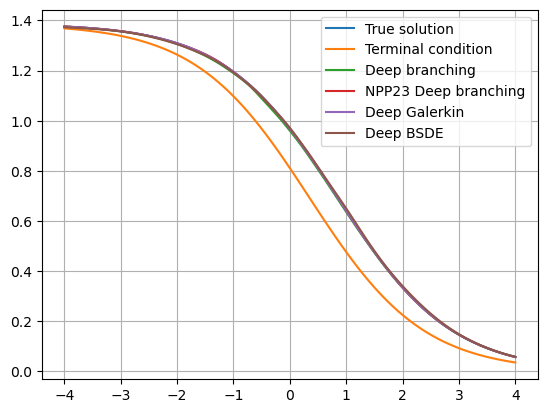

In [6]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="exp_example",
                    branch_nb_states=10000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=1000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Exponential nonlinearity in dimension d = 10 with T = 0.5

In [12]:
fixed_dim, dim = 0, 10

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y) - 10 * torch.exp(- y / 2) + torch.exp( y / 2) - torch.exp( y )

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y[0]) - 10 * torch.exp(- y[0] / 2) + torch.exp( y[0] / 2) - torch.exp( y[0] )

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + 6 + 4 * torch.exp(-y[0]) - 10 * torch.exp(- y[0] / 2) + torch.exp( y[0] / 2) - torch.exp( y[0] ) 

def phi_example(x):
    return 2* torch.log(1 + 1 / ( 1 + torch.exp(x.sum(dim=0) / math.sqrt(dim) )))

def exact_example(t, x, T):
    return 2*np.log(1 + 1/(1 + np.exp(x.sum(axis=0)/np.sqrt(dim) - (T - t))))

t_lo, x_lo, x_hi, n = 0., -8., 8., 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 400 seconds; L1 error: 2.01E-03; L2 error: 7.46E-06; rel error: 2.35E-03.
total runtime: 400 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 249 seconds; L1 error: 2.70E-03; L2 error: 9.02E-06; rel error: 3.42E-03.
fdb runtime: 0 seconds; total runtime: 249 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 250 seconds; L1 error: 1.65E-02; L2 error: 3.20E-04; rel error: 2.47E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 126 seconds; L1 error: 3.76E-03; L2 error: 1.70E-05; rel error: 5.71E-03.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 413 seconds; L1 error: 1.52E-03; L2 error: 3.54E-06; rel error: 1.98E-03.
total runtime: 413 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 245 seconds; L1 error: 2.65E-03; L

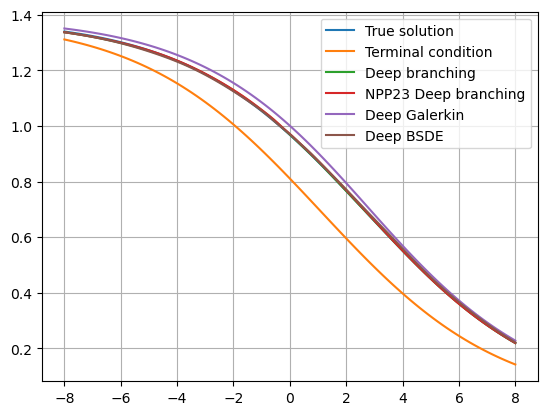

In [13]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, disable_branch_NPP23=True, disable_galerkin=True, disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="exp_example",
                    branch_nb_states=10000, branch_nb_path_per_state=2000, branch_nb_states_per_batch=1, 
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Exponential nonlinearity in dimension d = 100 with T = 0.5

In [8]:
fixed_dim, dim = 0, 100

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)
def f_example2(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y) - 10 * torch.exp(- y / 2) + torch.exp( y / 2) - torch.exp( y )

def f_example(y):
    """
    idx 0 -> no deriv
    """
    return 6 + 4 * torch.exp(-y[0]) - 10 * torch.exp(- y[0] / 2) + torch.exp( y[0] / 2) - torch.exp( y[0] )

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)
def dgm_f_example(y):
    """
    idx 0      -> no deriv
    idx 1 to n -> second deriv
    """
    return .5 * y[1:].sum(axis=0) + 6 + 4 * torch.exp(-y[0]) - 10 * torch.exp(- y[0] / 2) + torch.exp( y[0] / 2) - torch.exp( y[0] ) 

def phi_example(x):
    return 2* torch.log(1 + 1 / ( 1 + torch.exp(x.sum(dim=0) / math.sqrt(dim) )))

def exact_example(t, x, T):
    return 2*np.log(1 + 1/(1 + np.exp(x.sum(axis=0)/np.sqrt(dim) - (T - t))))

t_lo, t_hi, x_lo, x_hi, n = 0., 0.5, -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 326 seconds; L1 error: 5.19E-03; L2 error: 5.11E-05; rel error: 2.48E-02.
total runtime: 326 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 88 seconds; L1 error: 4.98E-03; L2 error: 1.18E-04; rel error: 2.10E-02.
fdb runtime: 0 seconds; total runtime: 88 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 232 seconds; L1 error: 3.50E-03; L2 error: 1.88E-05; rel error: 7.04E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 323 seconds; L1 error: 6.91E-03; L2 error: 1.59E-04; rel error: 2.09E-02.
total runtime: 323 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 85 seconds; L1 error: 5.72E-03; L2 error: 1.25E-04; rel error: 1.80E-02.
fdb runtime: 0 seconds; total runtime: 85 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Ti

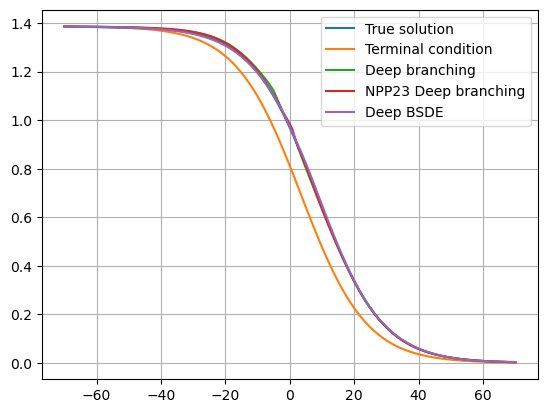

In [9]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, 
                    # disable_branch_NPP23=True, 
                    disable_galerkin=True, # disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="exp_example",
                    branch_nb_states=2000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

## Exponential nonlinearity in dimension d = 300 with T = 0.5

In [10]:
fixed_dim, dim = 0, 300

# function definition
deriv_map = np.array([0] * dim).reshape(-1, dim)

dgm_deriv_map = np.concatenate((deriv_map, 2 * np.identity(dim)), axis=0)

t_lo, t_hi, x_lo, x_hi, n = 0., 0.5, -7.*math.sqrt(dim), 7.*math.sqrt(dim), 0
grid = np.linspace(x_lo, x_hi, 100)
x_mid = (x_lo + x_hi) / 2
grid_d_dim = np.concatenate((x_mid * np.ones((fixed_dim, 100)), np.expand_dims(grid, axis=0), x_mid * np.ones((dim - fixed_dim - 1, 100))), axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = t_hi
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 1122 seconds; L1 error: 5.94E-03; L2 error: 7.64E-05; rel error: 1.90E-02.
total runtime: 1122 seconds.
#### Starting NPP23 deep branching method with seed 0 - 1 out of 10 times
Time taken: 181 seconds; L1 error: 8.40E-03; L2 error: 3.60E-04; rel error: 2.32E-02.
fdb runtime: 0 seconds; total runtime: 181 seconds.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 529 seconds; L1 error: 5.86E-03; L2 error: 5.97E-05; rel error: 1.80E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 1098 seconds; L1 error: 5.34E-03; L2 error: 6.76E-05; rel error: 1.61E-02.
total runtime: 1098 seconds.
#### Starting NPP23 deep branching method with seed 1 - 2 out of 10 times
Time taken: 185 seconds; L1 error: 7.07E-03; L2 error: 1.56E-04; rel error: 2.92E-02.
fdb runtime: 0 seconds; total runtime: 185 seconds.
#### Starting deep BSDE method with seed 1 - 2 out of 10 

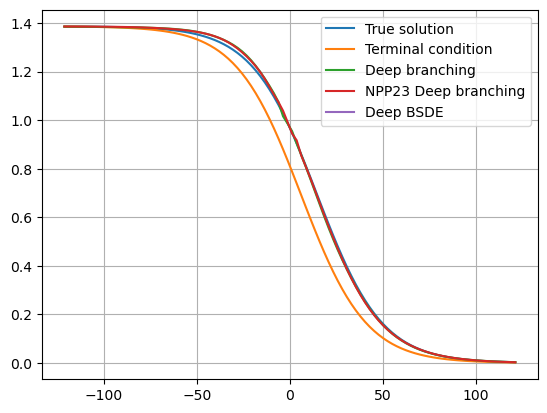

In [11]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    # verbose=True, debug_mode=True, 
                    # disable_branch=True, 
                    # disable_branch_NPP23=True, 
                    disable_galerkin=True, # disable_bsde=True,
                    T=T, device=device, epochs=3000, fname="exp_example",
                    branch_nb_states=2000, branch_nb_path_per_state=1000, branch_nb_states_per_batch=1,
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,                    
                    bsde_nb_states=100000, bsde_nb_time_intervals=4, outlier_percentile=1,
                    dgm_nb_states=10000, f_fun=f_example, f_fun2=f_example2, dgm_f_fun=dgm_f_example,
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)